# Validation Sets and Test Sets

The previous Colab exercises evaluated the trained model against the training set, which does not provide a strong signal about the quality of your model. In this Colab, you'll experiment with validation sets and test sets.






## Learning objectives

After doing this Colab, you'll know how to do the following:

  * Split a [training set](https://developers.google.com/machine-learning/glossary/#training_set) into a smaller training set and a [validation set](https://developers.google.com/machine-learning/glossary/#validation_set).
  * Analyze deltas between training set and validation set results.
  * Test the trained model with a [test set](https://developers.google.com/machine-learning/glossary/#test_set) to determine whether your trained model is [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting).
  * Detect and fix a common training problem.

## The dataset

As in the previous exercise, this exercise uses the [California Housing dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description) to predict the `median_house_value` at the city block level.  Like many "famous" datasets, the California Housing Dataset actually consists of two separate datasets, each living in separate .csv files:

* The training set is in `california_housing_train.csv`.
* The test set is in `california_housing_test.csv`.

You'll create the validation set by dividing the downloaded training set into two parts:

* a smaller training set  
* a validation set

## Import relevant modules

As before, this first code cell imports the necessary modules and sets a few display options.

In [1]:
#@title Import modules
import numpy as np
import pandas as pd
# import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

## Load the datasets from the internet

The following code cell loads the separate .csv files and creates the following two pandas DataFrames:

* `train_df`, which contains the training set.
* `test_df`, which contains the test set.



In [2]:
orign_train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

## Scale the label values

The following code cell scales the `median_house_value`. 
See the previous Colab exercise for details.

In [3]:
scale_factor = 1000.0

# Scale the training set's label.
orign_train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

## Load the functions that build and train a model

The following code cell defines two functions:

  * `build_model`, which defines the model's topography.
  * `train_model`, which will ultimately train the model, outputting not only the loss value for the training set but also the loss value for the validation set. 

Since you don't need to understand model building code right now, we've hidden this code cell. As always, you must run hidden code cells.

In [4]:
from torch import nn

class Sequential(nn.Module):
    def __init__(self):
        super(Sequential, self).__init__()
        self.hid = nn.Sequential(
                    nn.Linear(1, 1),
                )
    def forward(self, x):
        out = self.hid(x)
        return out
    
Sequential()

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)

In [5]:
feature = "median_income"    # the median income on a specific city block.
label = "median_house_value" # the median house value on a specific city block.

for batch in zip(orign_train_df[feature], orign_train_df[label]):
    # print(batch)
    pass

In [6]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

class My_Dataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        return (
            row["median_income"],
            row["median_house_value"])


    

In [7]:
# for batch in trainloader:
#     X, y = batch      

In [8]:
# from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split
import math

from tqdm.notebook import tqdm

learning_rate = 0.08
# learning_rate = 0.5
n_epochs = 30
batch_size = 100
validation_split = 0.2

In [9]:
train_df, valid_df = train_test_split(orign_train_df, test_size=validation_split, random_state=42, shuffle=True)

In [10]:
trainset = My_Dataset(train_df, transform = transform_train)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, pin_memory=True)

validset = My_Dataset(valid_df, transform = transform_train)

validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [11]:
model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    for batch in tqdm(trainloader):
        X, y = batch   
        X = X.unsqueeze(1).type(torch.FloatTensor)
        y = y.type(torch.FloatTensor)

        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(validloader):
        X, y = batch   
        X = X.unsqueeze(1).type(torch.FloatTensor)
        y = y.type(torch.FloatTensor)
        
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")

/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



[ Epoch | 001/030 ]           train_loss = 19784.77191 root_mean_squared_error = 140.65835  |           valid_loss = 17429.61699 val_root_mean_squared_error = 132.02127



[ Epoch | 002/030 ]           train_loss = 15971.27554 root_mean_squared_error = 126.37751  |           valid_loss = 15527.55744 val_root_mean_squared_error = 124.60962



[ Epoch | 003/030 ]           train_loss = 14446.15901 root_mean_squared_error = 120.19218  |           valid_loss = 14400.26787 val_root_mean_squared_error = 120.00112



[ Epoch | 004/030 ]           train_loss = 13688.55947 root_mean_squared_error = 116.99812  |           valid_loss = 13941.33691 val_root_mean_squared_error = 118.07344



[ Epoch | 005/030 ]           train_loss = 13439.75707 root_mean_squared_error = 115.92997  |           valid_loss = 13820.05934 val_root_mean_squared_error = 117.55875



[ Epoch | 006/030 ]           train_loss = 13387.30633 root_mean_squared_error = 115.70353  |           valid_loss = 13796.52203 val_root_mean_squared_error = 117.45860



[ Epoch | 007/030 ]           train_loss = 13379.14139 root_mean_squared_error = 115.66824  |           valid_loss = 13791.95993 val_root_mean_squared_error = 117.43918



[ Epoch | 008/030 ]           train_loss = 13377.94494 root_mean_squared_error = 115.66307  |           valid_loss = 13790.87543 val_root_mean_squared_error = 117.43456



[ Epoch | 009/030 ]           train_loss = 13377.74250 root_mean_squared_error = 115.66219  |           valid_loss = 13790.55908 val_root_mean_squared_error = 117.43321



[ Epoch | 010/030 ]           train_loss = 13377.69771 root_mean_squared_error = 115.66200  |           valid_loss = 13790.45502 val_root_mean_squared_error = 117.43277



[ Epoch | 011/030 ]           train_loss = 13377.68476 root_mean_squared_error = 115.66194  |           valid_loss = 13790.41883 val_root_mean_squared_error = 117.43261



[ Epoch | 012/030 ]           train_loss = 13377.68047 root_mean_squared_error = 115.66192  |           valid_loss = 13790.40639 val_root_mean_squared_error = 117.43256



[ Epoch | 013/030 ]           train_loss = 13377.67899 root_mean_squared_error = 115.66192  |           valid_loss = 13790.40151 val_root_mean_squared_error = 117.43254



[ Epoch | 014/030 ]           train_loss = 13377.67839 root_mean_squared_error = 115.66191  |           valid_loss = 13790.40016 val_root_mean_squared_error = 117.43253



[ Epoch | 015/030 ]           train_loss = 13377.67822 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39962 val_root_mean_squared_error = 117.43253



[ Epoch | 016/030 ]           train_loss = 13377.67809 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39933 val_root_mean_squared_error = 117.43253



[ Epoch | 017/030 ]           train_loss = 13377.67812 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39950 val_root_mean_squared_error = 117.43253



[ Epoch | 018/030 ]           train_loss = 13377.67807 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 019/030 ]           train_loss = 13377.67810 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 020/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 021/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 022/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 023/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 024/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 025/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 026/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 027/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 028/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 029/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253



[ Epoch | 030/030 ]           train_loss = 13377.67813 root_mean_squared_error = 115.66191  |           valid_loss = 13790.39924 val_root_mean_squared_error = 117.43253
Defined the build_model and train_model functions.


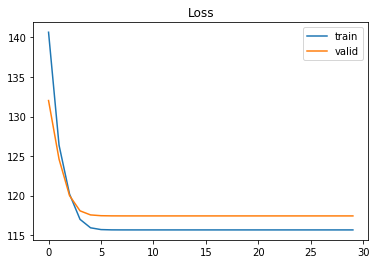

In [12]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.plot(epoch_valid_loss)
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.savefig('loss.png')
plt.show()

## Task 2: Determine **why** the loss curves differ

No matter how you split the training set and the validation set, the loss curves differ significantly. Evidently, the data in the training set isn't similar enough to the data in the validation set. Counterintuitive? Yes, but this problem is actually pretty common in machine learning. 

Your task is to determine **why** the loss curves aren't highly similar. As with most issues in machine learning, the problem is rooted in the data itself. To solve this mystery of why the training set and validation set aren't almost identical, write a line or two of [pandas code](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?utm_source=validation-colab&utm_medium=colab&utm_campaign=colab-external&utm_content=pandas_tf2-colab&hl=en) in the following code cell.  Here are a couple of hints:

  * The previous code cell split the original training set into:
    * a reduced training set (the original training set - the validation set)
    * the validation set 
  * By default, the pandas [`head`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method outputs the *first* 5 rows of the DataFrame. To see more of the training set, specify the `n` argument to `head` and assign a large positive integer to `n`.

In [13]:
#@title Double-click for a possible solution to Task 2.

# Examine examples 0 through 4 and examples 995 through 999
# of the training set
train_df.head(n=1000)

# The original training set is sorted by longitude. 
# Apparently, longitude influences the relationship of
# total_rooms to median_house_value.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4679,-118.1,33.8,22.0,2711.0,352.0,1305.0,368.0,8.5,398.8
2512,-117.6,33.5,12.0,3619.0,536.0,1506.0,492.0,7.2,353.6
993,-117.1,32.6,17.0,444.0,83.0,357.0,87.0,5.1,138.9
1327,-117.2,32.8,34.0,2275.0,375.0,1021.0,379.0,3.6,176.3
4630,-118.1,34.2,36.0,2415.0,394.0,1215.0,413.0,5.5,326.1
...,...,...,...,...,...,...,...,...,...
9048,-119.0,38.0,15.0,991.0,277.0,419.0,170.0,3.5,82.5
4913,-118.1,33.9,35.0,1151.0,248.0,809.0,246.0,4.8,160.0
1332,-117.2,32.8,32.0,1731.0,413.0,1569.0,427.0,3.3,154.3
14862,-122.2,37.8,52.0,2721.0,541.0,1185.0,515.0,4.5,239.8


## Task 3. Fix the problem

To fix the problem, shuffle the examples in the training set before splitting the examples into a training set and validation set. To do so, take the following steps:

1. Shuffle the data in the training set by adding the following line anywhere before you call `train_model` (in the code cell associated with Task 1):

```
  shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))
```                                    

2. Pass `shuffled_train_df` (instead of `train_df`) as the second argument to `train_model` (in the code call associated with Task 1) so that the call becomes as follows:

```
  epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature, 
                                      my_label, epochs, batch_size, 
                                      validation_split)
```

In [14]:
shuffled_train_df = orign_train_df.reindex(np.random.permutation(orign_train_df.index))

train_df, valid_df = train_test_split(shuffled_train_df, test_size=validation_split, random_state=42, shuffle=True)


trainset = My_Dataset(train_df, transform = transform_train)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, pin_memory=True)

validset = My_Dataset(valid_df, transform = transform_train)

validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [15]:
n_epochs = 70

model = Sequential()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()   
    
    
epoch_train_loss = []

epoch_valid_loss = []

    
for epoch in range(n_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []    
    
    for batch in tqdm(trainloader):
        X, y = batch   
        X = X.unsqueeze(1).type(torch.FloatTensor)
        y = y.type(torch.FloatTensor)

        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        
    train_loss = sum(train_loss) / len(train_loss)
    
    epoch_train_loss.append(math.sqrt(train_loss))
   
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    
    # These are used to record information in validation.
    valid_loss = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(validloader):
        X, y = batch   
        X = X.unsqueeze(1).type(torch.FloatTensor)
        y = y.type(torch.FloatTensor)
        
        y_hat = model(X)
        loss = loss_func(y_hat, y) #rmse
        
        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        
     # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_loss.append(math.sqrt(valid_loss))
        
    # Print the information.
    print(f"[ Epoch | {epoch + 1:03d}/{n_epochs:03d} ] \
          train_loss = {train_loss:.5f} root_mean_squared_error = {math.sqrt(train_loss):.5f}  | \
          valid_loss = {valid_loss:.5f} val_root_mean_squared_error = {math.sqrt(valid_loss):.5f}")

print("Defined the build_model and train_model functions.")


[ Epoch | 001/070 ]           train_loss = 19657.65811 root_mean_squared_error = 140.20577  |           valid_loss = 17057.07252 val_root_mean_squared_error = 130.60273



[ Epoch | 002/070 ]           train_loss = 15998.95162 root_mean_squared_error = 126.48696  |           valid_loss = 15186.79435 val_root_mean_squared_error = 123.23471



[ Epoch | 003/070 ]           train_loss = 14520.58765 root_mean_squared_error = 120.50140  |           valid_loss = 14102.98788 val_root_mean_squared_error = 118.75600



[ Epoch | 004/070 ]           train_loss = 13794.97271 root_mean_squared_error = 117.45200  |           valid_loss = 13656.13011 val_root_mean_squared_error = 116.85945



[ Epoch | 005/070 ]           train_loss = 13545.98099 root_mean_squared_error = 116.38720  |           valid_loss = 13524.70060 val_root_mean_squared_error = 116.29575



[ Epoch | 006/070 ]           train_loss = 13484.63815 root_mean_squared_error = 116.12337  |           valid_loss = 13493.01100 val_root_mean_squared_error = 116.15942



[ Epoch | 007/070 ]           train_loss = 13472.29043 root_mean_squared_error = 116.07020  |           valid_loss = 13485.26775 val_root_mean_squared_error = 116.12609



[ Epoch | 008/070 ]           train_loss = 13469.97228 root_mean_squared_error = 116.06021  |           valid_loss = 13483.07850 val_root_mean_squared_error = 116.11666



[ Epoch | 009/070 ]           train_loss = 13469.54018 root_mean_squared_error = 116.05835  |           valid_loss = 13482.34616 val_root_mean_squared_error = 116.11351



[ Epoch | 010/070 ]           train_loss = 13469.45842 root_mean_squared_error = 116.05800  |           valid_loss = 13482.06865 val_root_mean_squared_error = 116.11231



[ Epoch | 011/070 ]           train_loss = 13469.44271 root_mean_squared_error = 116.05793  |           valid_loss = 13481.95542 val_root_mean_squared_error = 116.11182



[ Epoch | 012/070 ]           train_loss = 13469.43922 root_mean_squared_error = 116.05791  |           valid_loss = 13481.90766 val_root_mean_squared_error = 116.11162



[ Epoch | 013/070 ]           train_loss = 13469.43844 root_mean_squared_error = 116.05791  |           valid_loss = 13481.88724 val_root_mean_squared_error = 116.11153



[ Epoch | 014/070 ]           train_loss = 13469.43831 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87819 val_root_mean_squared_error = 116.11149



[ Epoch | 015/070 ]           train_loss = 13469.43810 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87434 val_root_mean_squared_error = 116.11147



[ Epoch | 016/070 ]           train_loss = 13469.43824 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87264 val_root_mean_squared_error = 116.11147



[ Epoch | 017/070 ]           train_loss = 13469.43810 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87221 val_root_mean_squared_error = 116.11146



[ Epoch | 018/070 ]           train_loss = 13469.43817 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87184 val_root_mean_squared_error = 116.11146



[ Epoch | 019/070 ]           train_loss = 13469.43820 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87161 val_root_mean_squared_error = 116.11146



[ Epoch | 020/070 ]           train_loss = 13469.43815 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87170 val_root_mean_squared_error = 116.11146



[ Epoch | 021/070 ]           train_loss = 13469.43820 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87152 val_root_mean_squared_error = 116.11146



[ Epoch | 022/070 ]           train_loss = 13469.43815 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 023/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 024/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 025/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 026/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 027/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 028/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 029/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 030/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 031/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 032/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 033/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 034/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 035/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 036/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 037/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 038/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 039/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 040/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 041/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 042/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 043/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 044/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 045/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 046/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 047/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 048/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 049/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 050/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 051/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 052/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 053/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 054/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 055/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 056/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 057/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 058/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 059/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 060/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 061/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 062/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 063/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 064/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 065/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 066/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 067/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 068/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 069/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146



[ Epoch | 070/070 ]           train_loss = 13469.43816 root_mean_squared_error = 116.05791  |           valid_loss = 13481.87150 val_root_mean_squared_error = 116.11146
Defined the build_model and train_model functions.


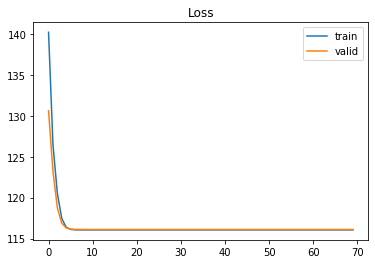

In [16]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(epoch_train_loss)
plt.plot(epoch_valid_loss)
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.savefig('loss.png')
plt.show()

## Task 4: Use the Test Dataset to Evaluate Your Model's Performance

The test set usually acts as the ultimate judge of a model's quality. The test set can serve as an impartial judge because its examples haven't been used in training the model. Run the following code cell to evaluate the model with the test set:

In [17]:
testset = My_Dataset(test_df, transform = transform_test)

testloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [18]:
model.eval()

Sequential(
  (hid): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)

In [19]:
# These are used to record information in validation.
test_loss = []

# Iterate the validation set by batches.
for batch in tqdm(testloader):
    X, y = batch   
    X = X.unsqueeze(1).type(torch.FloatTensor)
    y = y.type(torch.FloatTensor)

    y_hat = model(X)
    loss = loss_func(y_hat, y) #rmse

    # Record the loss and accuracy.
    test_loss.append(loss.item())

 # The average loss and accuracy for entire validation set is the average of the recorded values.
test_loss = sum(test_loss) / len(test_loss)

# Print the information.
print(f"test_loss = {test_loss:.5f} root_mean_squared_error = {math.sqrt(test_loss):.5f}")


test_loss = 13453.72529 root_mean_squared_error = 115.99019


Compare the root mean squared error of the model when evaluated on each of the three datasets:

* training set: look for `root_mean_squared_error` in the final training epoch.
* validation set: look for `val_root_mean_squared_error` in the final training epoch.
* test set: run the preceding code cell and examine the `root_mean_squared_error`.

Ideally, the root mean squared error of all three sets should be similar. Are they?